### imports

In [1]:
import pandas as pd
import numpy as np
import bootcampviztools as bt
import matplotlib.pyplot as plt
import seaborn as sns
import TeamChallenge_ML_completo as tc

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


import warnings

# Suprime todos los warnings
warnings.filterwarnings("ignore")

sample = pd.read_csv("data/sample_submission.csv")
import urllib.request
from PIL import Image
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Iván y Manuel: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `laptops_test.csv`. Lloramos.")

### cargar los datos

In [2]:
train = pd.read_csv("./data/train.csv", index_col=0)
train.index.name =None

test = pd.read_csv("./data/test.csv", index_col=0)
test.index.name = None

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [4]:
train.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


In [5]:
target = "Price_in_euros"

### limpieza

In [6]:
train["ram_gb"] =  train["Ram"].str.replace("GB", "").astype(int)
train["weight_kg"]= train["Weight"].str.replace("kg", "").astype(float)

test["ram_gb"] =  test["Ram"].str.replace("GB", "").astype(int)
test["weight_kg"]= test["Weight"].str.replace("kg", "").astype(float)

In [7]:
def convert_to_gb(memory):
    total_gb = 0
    capacities = memory.split('+')
    for capacity in capacities:
        if 'TB' in capacity:
            total_gb += int(float(capacity.split('TB')[0]) * 1024)
        elif 'GB' in capacity:
            total_gb += int(float(capacity.split('GB')[0]))
    return total_gb


train['storage_gb'] = train['Memory'].apply(convert_to_gb)

test["storage_gb"] = test["Memory"].apply(convert_to_gb)

In [8]:
train.drop(columns=["Ram", "Weight", "Memory"], inplace=True)
test.drop(columns=["Ram", "Weight", "Memory"], inplace=True)

### minieda

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Gpu               912 non-null    object 
 7   OpSys             912 non-null    object 
 8   Price_in_euros    912 non-null    float64
 9   ram_gb            912 non-null    int32  
 10  weight_kg         912 non-null    float64
 11  storage_gb        912 non-null    int64  
dtypes: float64(3), int32(1), int64(1), object(7)
memory usage: 89.1+ KB


In [10]:
cat_col = ['Company', 'Product', 'TypeName', 'ScreenResolution', 'Cpu',
       'Gpu', 'OpSys']

In [11]:
for col in cat_col:
    print(col, train[col].nunique())

Company 19
Product 480
TypeName 6
ScreenResolution 36
Cpu 107
Gpu 93
OpSys 9


In [12]:
train.drop(columns=["Product"], inplace=True)
test.drop(columns=["Product"], inplace=True)

cat_col.remove("Product")

### imposible de visualizar: transformar categoricas

#### screenresolution

In [13]:
train.ScreenResolution.value_counts()

ScreenResolution
Full HD 1920x1080                                349
1366x768                                         211
IPS Panel Full HD 1920x1080                      163
IPS Panel Full HD / Touchscreen 1920x1080         32
Full HD / Touchscreen 1920x1080                   30
1600x900                                          14
Quad HD+ / Touchscreen 3200x1800                  11
Touchscreen 1366x768                              11
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     10
4K Ultra HD / Touchscreen 3840x2160                7
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
Touchscreen 2560x1440                              6
IPS Panel 4K Ultra HD 3840x2160                    5
Touchscreen 2256x1504                              5
IPS Panel Retina Display 2560x1600                 5
1440x900                                           4
IPS Panel 1366x768                                 4
IPS Panel Retina Display 2304x1440                 4
IPS Panel Touchscreen 2560x14

In [14]:
train['retina'] = train['ScreenResolution'].str.contains('Retina').astype(int)
train['ips'] = train['ScreenResolution'].str.contains('IPS').astype(int)
train['touchscreen'] = train['ScreenResolution'].str.contains('Touchscreen').astype(int)

train['ScreenResolution'] = train['ScreenResolution'].str.extract(r'(\b\d{3,4}x\d{3,4}\b)', expand=False)

resolucion_a_nombre = {
    '1920x1080': 'Full HD',
    '1366x768': 'HD',
    '3840x2160': '4K UHD',
    '3200x1800': 'QHD+',
    '2560x1440': 'QHD',
    '1600x900': 'HD+',
    '2560x1600': 'WQXGA',
    '2256x1504': 'Surface Laptop (3:2 aspect ratio)',
    '1440x900': 'WXGA+',
    '2304x1440': 'MacBook (12-inch Retina)',
    '1920x1200': 'WUXGA',
    '2880x1800': 'MacBook Pro Retina',
    '2160x1440': 'Surface Pro',
    '2400x1600': 'WQSXGA'
}
train['resolution'] = train['ScreenResolution'].map(resolucion_a_nombre)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   TypeName          912 non-null    object 
 2   Inches            912 non-null    float64
 3   ScreenResolution  912 non-null    object 
 4   Cpu               912 non-null    object 
 5   Gpu               912 non-null    object 
 6   OpSys             912 non-null    object 
 7   Price_in_euros    912 non-null    float64
 8   ram_gb            912 non-null    int32  
 9   weight_kg         912 non-null    float64
 10  storage_gb        912 non-null    int64  
 11  retina            912 non-null    int32  
 12  ips               912 non-null    int32  
 13  touchscreen       912 non-null    int32  
 14  resolution        912 non-null    object 
dtypes: float64(3), int32(4), int64(1), object(7)
memory usage: 99.8+ KB


In [16]:
test.loc[428]

Company                                            Chuwi
TypeName                                        Notebook
Inches                                              12.3
ScreenResolution      IPS Panel Retina Display 2736x1824
Cpu                 Intel Celeron Quad Core N3450 1.1GHz
Gpu                                Intel HD Graphics 500
OpSys                                         Windows 10
ram_gb                                                 6
weight_kg                                            1.4
storage_gb                                            64
Name: 428, dtype: object

In [17]:
test['retina'] = test['ScreenResolution'].str.contains('Retina').astype(int)
test['ips'] = test['ScreenResolution'].str.contains('IPS').astype(int)
test['touchscreen'] = test['ScreenResolution'].str.contains('Touchscreen').astype(int)

test['ScreenResolution'] = test['ScreenResolution'].str.extract(r'(\b\d{3,4}x\d{3,4}\b)', expand=False)

test['resolution'] = test['ScreenResolution'].map(resolucion_a_nombre)

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           391 non-null    object 
 1   TypeName          391 non-null    object 
 2   Inches            391 non-null    float64
 3   ScreenResolution  391 non-null    object 
 4   Cpu               391 non-null    object 
 5   Gpu               391 non-null    object 
 6   OpSys             391 non-null    object 
 7   ram_gb            391 non-null    int32  
 8   weight_kg         391 non-null    float64
 9   storage_gb        391 non-null    int64  
 10  retina            391 non-null    int32  
 11  ips               391 non-null    int32  
 12  touchscreen       391 non-null    int32  
 13  resolution        390 non-null    object 
dtypes: float64(2), int32(4), int64(1), object(7)
memory usage: 47.8+ KB


In [19]:
test["resolution"].fillna("2736x1824", inplace=True)

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           391 non-null    object 
 1   TypeName          391 non-null    object 
 2   Inches            391 non-null    float64
 3   ScreenResolution  391 non-null    object 
 4   Cpu               391 non-null    object 
 5   Gpu               391 non-null    object 
 6   OpSys             391 non-null    object 
 7   ram_gb            391 non-null    int32  
 8   weight_kg         391 non-null    float64
 9   storage_gb        391 non-null    int64  
 10  retina            391 non-null    int32  
 11  ips               391 non-null    int32  
 12  touchscreen       391 non-null    int32  
 13  resolution        391 non-null    object 
dtypes: float64(2), int32(4), int64(1), object(7)
memory usage: 47.8+ KB


In [21]:
train.drop(columns=["ScreenResolution"], inplace=True)
test.drop(columns=["ScreenResolution"], inplace=True)

In [22]:
cat_col = cat_col + ["retina", "ips", "touchscreen"]

In [23]:
cat_col.remove("ScreenResolution")
cat_col.append("resolution")

#### cpu

In [24]:
cepeu = train['Cpu'].str.extract(r'([A-Za-z]+)\s.*\s([0-9.]+)GHz')
cepeu[1] = cepeu[1].astype(float)
cepeu['Categoria'] = pd.cut(cepeu[1], bins=[-float('inf'), 2, 3, float('inf')], labels=[3,2,1])
cepeu["Categoria"] = cepeu["Categoria"].astype(object)
train["cpu"] = cepeu[0] + " " + cepeu["Categoria"].astype(str)

In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      391 non-null    object 
 1   TypeName     391 non-null    object 
 2   Inches       391 non-null    float64
 3   Cpu          391 non-null    object 
 4   Gpu          391 non-null    object 
 5   OpSys        391 non-null    object 
 6   ram_gb       391 non-null    int32  
 7   weight_kg    391 non-null    float64
 8   storage_gb   391 non-null    int64  
 9   retina       391 non-null    int32  
 10  ips          391 non-null    int32  
 11  touchscreen  391 non-null    int32  
 12  resolution   391 non-null    object 
dtypes: float64(2), int32(4), int64(1), object(6)
memory usage: 44.8+ KB


In [26]:
cepeu = test['Cpu'].str.extract(r'([A-Za-z]+)\s.*\s([0-9.]+)GHz')
cepeu[1] = cepeu[1].astype(float)
cepeu['Categoria'] = pd.cut(cepeu[1], bins=[-float('inf'), 2, 3, float('inf')], labels=[3,2,1])
cepeu["Categoria"] = cepeu["Categoria"].astype(object)
test["cpu"] = cepeu[0] + " " + cepeu["Categoria"].astype(str)

In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      391 non-null    object 
 1   TypeName     391 non-null    object 
 2   Inches       391 non-null    float64
 3   Cpu          391 non-null    object 
 4   Gpu          391 non-null    object 
 5   OpSys        391 non-null    object 
 6   ram_gb       391 non-null    int32  
 7   weight_kg    391 non-null    float64
 8   storage_gb   391 non-null    int64  
 9   retina       391 non-null    int32  
 10  ips          391 non-null    int32  
 11  touchscreen  391 non-null    int32  
 12  resolution   391 non-null    object 
 13  cpu          391 non-null    object 
dtypes: float64(2), int32(4), int64(1), object(7)
memory usage: 47.8+ KB


In [28]:
train.drop(columns=["Cpu"], inplace=True)
test.drop(columns=["Cpu"], inplace=True)

In [29]:
cat_col.remove("Cpu")
cat_col.append("cpu")

#### gpu

In [30]:
train['gpu'] = train['Gpu'].str.split().str[0]
test['gpu'] = test['Gpu'].str.split().str[0]

In [31]:
train.drop(columns=["Gpu"], inplace=True)
test.drop(columns=["Gpu"], inplace=True)

In [32]:
cat_col.remove("Gpu")
cat_col.append("gpu")

In [33]:
for col in cat_col:
    print(col, train[col].nunique())

Company 19
TypeName 6
OpSys 9
retina 2
ips 2
touchscreen 2
resolution 14
cpu 6
gpu 3


In [34]:
train

,Company,TypeName,Inches,OpSys,Price_in_euros,ram_gb,weight_kg,storage_gb,retina,ips,touchscreen,resolution,cpu,gpu
755,HP,Notebook,15.6,Windows 10,539.00,8,1.86,256,0,0,0,Full HD,Intel 3,Intel
618,Dell,Gaming,15.6,Windows 10,879.01,16,2.59,1024,0,0,0,Full HD,Intel 2,Nvidia
909,HP,Notebook,15.6,Windows 10,900.00,8,2.04,1024,0,0,0,Full HD,Intel 2,Nvidia
2,Apple,Ultrabook,13.3,macOS,898.94,8,1.34,128,0,0,0,WXGA+,Intel 3,Intel
286,Dell,Notebook,15.6,Linux,428.00,4,2.25,1024,0,0,0,Full HD,Intel 3,AMD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Dell,Notebook,15.6,Windows 10,800.00,8,2.20,256,0,0,0,Full HD,Intel 3,AMD
1160,HP,2 in 1 Convertible,13.3,Windows 10,1629.00,8,1.48,256,0,0,1,Full HD,Intel 2,Intel
78,Lenovo,Notebook,15.6,No OS,519.00,8,2.20,2048,0,0,0,Full HD,Intel 2,Intel
23,HP,Notebook,15.6,No OS,258.00,4,1.86,500,0,0,0,HD,AMD 3,AMD


### minieda con las columnas arregladas

In [35]:
cat_col = []
for col in train.columns:
    print(col, train[col].nunique())
    if train[col].nunique() < 30:
        cat_col.append(col)


Company 19
TypeName 6
Inches 17
OpSys 9
Price_in_euros 603
ram_gb 9
weight_kg 158
storage_gb 22
retina 2
ips 2
touchscreen 2
resolution 14
cpu 6
gpu 3


In [36]:
cat_col

['Company',
 'TypeName',
 'Inches',
 'OpSys',
 'ram_gb',
 'storage_gb',
 'retina',
 'ips',
 'touchscreen',
 'resolution',
 'cpu',
 'gpu']

In [37]:
# tc.plot_features_cat_regression(train, target, cat_col, 1)

In [38]:
# columnas = ["ram_gb", "storage_gb", "Inches", "retina", "ips", "touchscreen"]

# filas = (len(columnas) + 2) // 3
# fig, axs = plt.subplots(filas, 3, figsize=(15, 5 * filas))
# contador = 0

# for col in columnas:
#     fila_actual = contador // 3
#     columna_actual = contador % 3
#     sns.histplot(data=train, x=target, hue=col, bins=50, kde=True, palette="tab10", ax=axs[fila_actual, columna_actual])
#     axs[fila_actual, columna_actual].set_title(col)
#     contador += 1
# plt.tight_layout()
# plt.show()

### más retoques

In [39]:
# me quedo con storage y inches como categoricas voy a empaquetarlas un poco más
for col in cat_col:
    print(col, train[col].nunique())

Company 19
TypeName 6
Inches 17
OpSys 9
ram_gb 9
storage_gb 22
retina 2
ips 2
touchscreen 2
resolution 14
cpu 6
gpu 3


#### inches


In [40]:
# INCHES

limite_grande = 15.0
limite_mediano = 13.0

# Crear una nueva columna 'Categoria' utilizando una expresión condicional
train['inches'] = [3 if x >= limite_grande else 2 if x >= limite_mediano else 1 for x in train['Inches']]

test['inches'] = [3 if x >= limite_grande else 2 if x >= limite_mediano else 1 for x in test['Inches']]

In [41]:
cat_col.remove("Inches")
cat_col.append("inches")

#### storage

In [42]:
train["storage_gb"].value_counts().sort_index()

storage_gb
8         1
16        9
32       39
64       12
128      59
180       3
240       1
256     289
500      92
508       1
512      85
756       1
768       1
1024    171
1088      1
1152     67
1280     52
1536      8
2048     11
2176      1
2304      6
2560      2
Name: count, dtype: int64

In [43]:
limite_muy_bajo = 100
limite_bajo = 500
limite_alto = 1000
limite_muy_alto = 2000

# Crear una nueva columna 'storage' utilizando una expresión condicional
train['storage'] = [1 if x <= limite_muy_bajo else 2 if x <= limite_bajo else 3 if x <= limite_alto else 4 if x <= limite_muy_alto else 5 for x in train['storage_gb']]
test['storage'] = [1 if x <= limite_muy_bajo else 2 if x <= limite_bajo else 3 if x <= limite_alto else 4 if x <= limite_muy_alto else 5 for x in test['storage_gb']]


In [44]:
train[["storage", "storage_gb"]]

,storage,storage_gb
755,2,256
618,4,1024
909,4,1024
2,2,128
286,4,1024
...,...,...
28,2,256
1160,2,256
78,5,2048
23,2,500


In [45]:
cat_col.remove("storage_gb")
cat_col.append("storage")

In [46]:
train.drop(columns=["Inches", "storage_gb"], inplace=True)
test.drop(columns=["Inches", "storage_gb"], inplace=True)

In [47]:
for col in cat_col:
    print(col, train[col].nunique())

Company 19
TypeName 6
OpSys 9
ram_gb 9
retina 2
ips 2
touchscreen 2
resolution 14
cpu 6
gpu 3
inches 3
storage 5


In [48]:
train

,Company,TypeName,OpSys,Price_in_euros,ram_gb,weight_kg,retina,ips,touchscreen,resolution,cpu,gpu,inches,storage
755,HP,Notebook,Windows 10,539.00,8,1.86,0,0,0,Full HD,Intel 3,Intel,3,2
618,Dell,Gaming,Windows 10,879.01,16,2.59,0,0,0,Full HD,Intel 2,Nvidia,3,4
909,HP,Notebook,Windows 10,900.00,8,2.04,0,0,0,Full HD,Intel 2,Nvidia,3,4
2,Apple,Ultrabook,macOS,898.94,8,1.34,0,0,0,WXGA+,Intel 3,Intel,2,2
286,Dell,Notebook,Linux,428.00,4,2.25,0,0,0,Full HD,Intel 3,AMD,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Dell,Notebook,Windows 10,800.00,8,2.20,0,0,0,Full HD,Intel 3,AMD,3,2
1160,HP,2 in 1 Convertible,Windows 10,1629.00,8,1.48,0,0,1,Full HD,Intel 2,Intel,2,2
78,Lenovo,Notebook,No OS,519.00,8,2.20,0,0,0,Full HD,Intel 2,Intel,3,5
23,HP,Notebook,No OS,258.00,4,1.86,0,0,0,HD,AMD 3,AMD,3,2


### ordinal encoding
ordinal encoding de las categorias con alta cardinalidad para no tener 5mil columnas

In [49]:
train

,Company,TypeName,OpSys,Price_in_euros,ram_gb,weight_kg,retina,ips,touchscreen,resolution,cpu,gpu,inches,storage
755,HP,Notebook,Windows 10,539.00,8,1.86,0,0,0,Full HD,Intel 3,Intel,3,2
618,Dell,Gaming,Windows 10,879.01,16,2.59,0,0,0,Full HD,Intel 2,Nvidia,3,4
909,HP,Notebook,Windows 10,900.00,8,2.04,0,0,0,Full HD,Intel 2,Nvidia,3,4
2,Apple,Ultrabook,macOS,898.94,8,1.34,0,0,0,WXGA+,Intel 3,Intel,2,2
286,Dell,Notebook,Linux,428.00,4,2.25,0,0,0,Full HD,Intel 3,AMD,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Dell,Notebook,Windows 10,800.00,8,2.20,0,0,0,Full HD,Intel 3,AMD,3,2
1160,HP,2 in 1 Convertible,Windows 10,1629.00,8,1.48,0,0,1,Full HD,Intel 2,Intel,2,2
78,Lenovo,Notebook,No OS,519.00,8,2.20,0,0,0,Full HD,Intel 2,Intel,3,5
23,HP,Notebook,No OS,258.00,4,1.86,0,0,0,HD,AMD 3,AMD,3,2


#### company

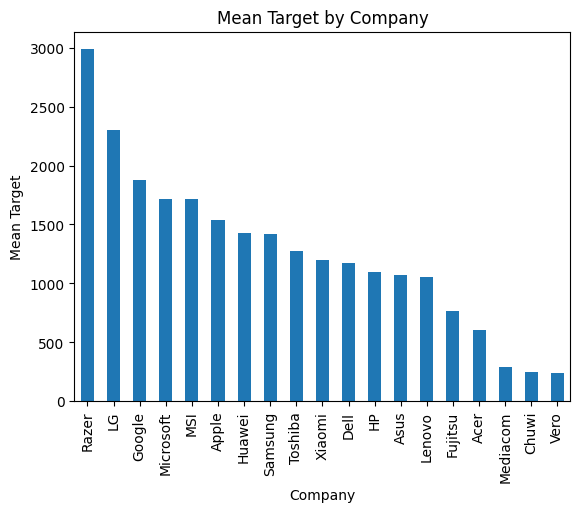

In [50]:
company_means = train.groupby('Company')[target].mean()
company_means=company_means.sort_values(ascending=False)

# Visualiza los resultados
company_means.plot(kind='bar')
plt.xlabel('Company')
plt.ylabel('Mean Target')
plt.title('Mean Target by Company')
plt.show()


In [51]:
ordinal_encoding = {company: index for index, company in enumerate(company_means.sort_values(ascending=False).index)}

train['Company'] = train['Company'].map(ordinal_encoding)
test['Company'] = test['Company'].map(ordinal_encoding)

#### typename

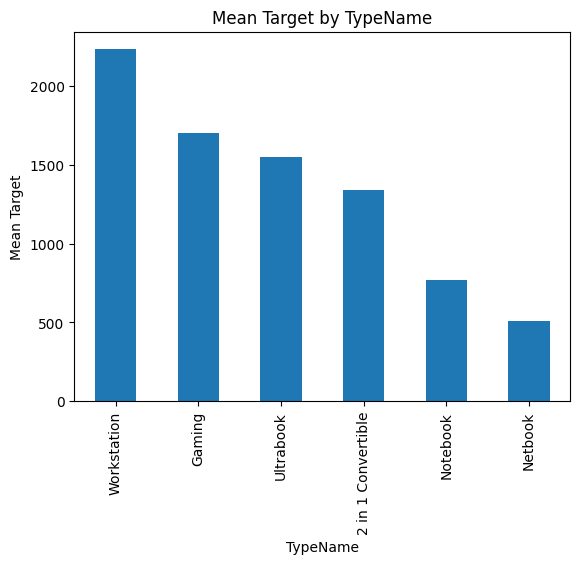

In [52]:
TypeName_means = train.groupby('TypeName')[target].mean()
TypeName_means=TypeName_means.sort_values(ascending=False)

# Visualiza los resultados
TypeName_means.plot(kind='bar')
plt.xlabel('TypeName')
plt.ylabel('Mean Target')
plt.title('Mean Target by TypeName')
plt.show()


In [53]:
ordinal_encoding = {TypeName: index for index, TypeName in enumerate(TypeName_means.sort_values(ascending=False).index)}

train['TypeName'] = train['TypeName'].map(ordinal_encoding)
test['TypeName'] = test['TypeName'].map(ordinal_encoding)

#### opsys


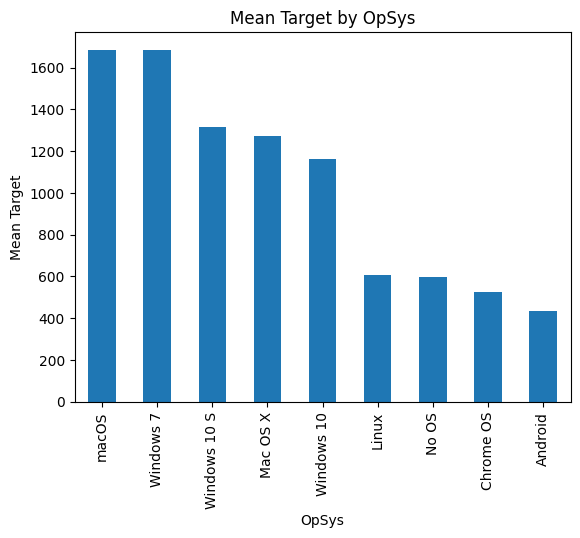

In [54]:
OpSys_means = train.groupby('OpSys')[target].mean()
OpSys_means=OpSys_means.sort_values(ascending=False)

# Visualiza los resultados
OpSys_means.plot(kind='bar')
plt.xlabel('OpSys')
plt.ylabel('Mean Target')
plt.title('Mean Target by OpSys')
plt.show()


In [55]:
ordinal_encoding = {OpSys: index for index, OpSys in enumerate(OpSys_means.sort_values(ascending=False).index)}

train['OpSys'] = train['OpSys'].map(ordinal_encoding)
test['OpSys'] = test['OpSys'].map(ordinal_encoding)

#### resolution


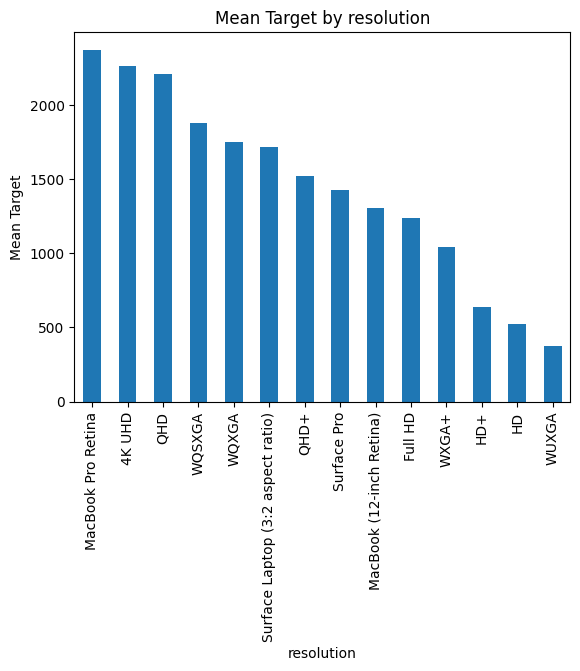

In [56]:
resolution_means = train.groupby('resolution')[target].mean()
resolution_means=resolution_means.sort_values(ascending=False)

# Visualiza los resultados
resolution_means.plot(kind='bar')
plt.xlabel('resolution')
plt.ylabel('Mean Target')
plt.title('Mean Target by resolution')
plt.show()

In [57]:
test

,Company,TypeName,OpSys,ram_gb,weight_kg,retina,ips,touchscreen,resolution,cpu,gpu,inches,storage
209,13,1,6,16,2.400,0,0,0,Full HD,Intel 2,Nvidia,3,3
1281,15,4,5,4,2.400,0,0,0,HD,Intel 3,Intel,3,2
1168,13,4,6,4,1.900,0,0,0,HD,Intel 3,Intel,3,4
1231,10,3,4,8,2.191,0,1,1,Full HD,Intel 2,Intel,3,2
1020,11,4,4,4,1.950,0,0,0,Full HD,Intel 2,Intel,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,4,1,4,16,2.900,0,0,0,Full HD,Intel 2,Nvidia,3,4
948,8,4,4,4,1.470,0,1,0,Full HD,Intel 2,Intel,2,2
483,10,0,4,8,1.780,0,0,0,Full HD,Intel 2,Nvidia,3,2
1017,11,4,4,4,1.640,0,0,0,HD,Intel 2,Intel,2,2


In [58]:
ordinal_encoding = {resolution: index for index, resolution in enumerate(resolution_means.sort_values(ascending=False).index)}

train['resolution'] = train['resolution'].map(ordinal_encoding)
test['resolution'] = test['resolution'].map(ordinal_encoding)

In [59]:
test[test["resolution"].isna()]

,Company,TypeName,OpSys,ram_gb,weight_kg,retina,ips,touchscreen,resolution,cpu,gpu,inches,storage
428,17,4,4,6,1.4,1,1,0,NaN,Intel 3,Intel,1,1


In [60]:
test["resolution"].fillna(14, inplace=True)

In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      391 non-null    int64  
 1   TypeName     391 non-null    int64  
 2   OpSys        391 non-null    int64  
 3   ram_gb       391 non-null    int32  
 4   weight_kg    391 non-null    float64
 5   retina       391 non-null    int32  
 6   ips          391 non-null    int32  
 7   touchscreen  391 non-null    int32  
 8   resolution   391 non-null    float64
 9   cpu          391 non-null    object 
 10  gpu          391 non-null    object 
 11  inches       391 non-null    int64  
 12  storage      391 non-null    int64  
dtypes: float64(2), int32(4), int64(5), object(2)
memory usage: 44.8+ KB


#### cpu


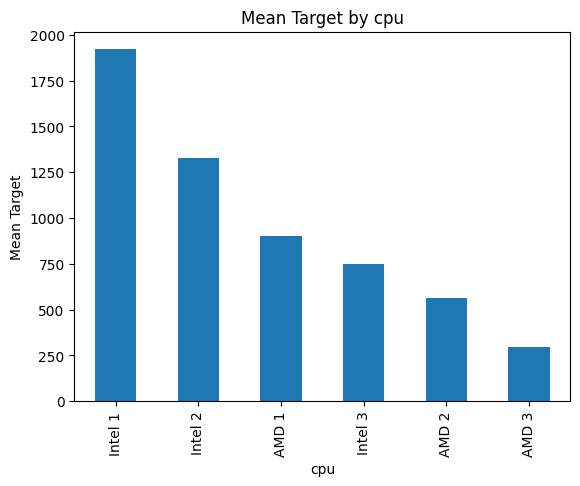

In [62]:
cpu_means = train.groupby('cpu')[target].mean()
cpu_means=cpu_means.sort_values(ascending=False)

# Visualiza los resultados
cpu_means.plot(kind='bar')
plt.xlabel('cpu')
plt.ylabel('Mean Target')
plt.title('Mean Target by cpu')
plt.show()

In [63]:
ordinal_encoding = {cpu: index for index, cpu in enumerate(cpu_means.sort_values(ascending=False).index)}

train['cpu'] = train['cpu'].map(ordinal_encoding)
test['cpu'] = test['cpu'].map(ordinal_encoding)

In [64]:
test["cpu"].fillna(6, inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      391 non-null    int64  
 1   TypeName     391 non-null    int64  
 2   OpSys        391 non-null    int64  
 3   ram_gb       391 non-null    int32  
 4   weight_kg    391 non-null    float64
 5   retina       391 non-null    int32  
 6   ips          391 non-null    int32  
 7   touchscreen  391 non-null    int32  
 8   resolution   391 non-null    float64
 9   cpu          391 non-null    float64
 10  gpu          391 non-null    object 
 11  inches       391 non-null    int64  
 12  storage      391 non-null    int64  
dtypes: float64(3), int32(4), int64(5), object(1)
memory usage: 44.8+ KB


#### gpu

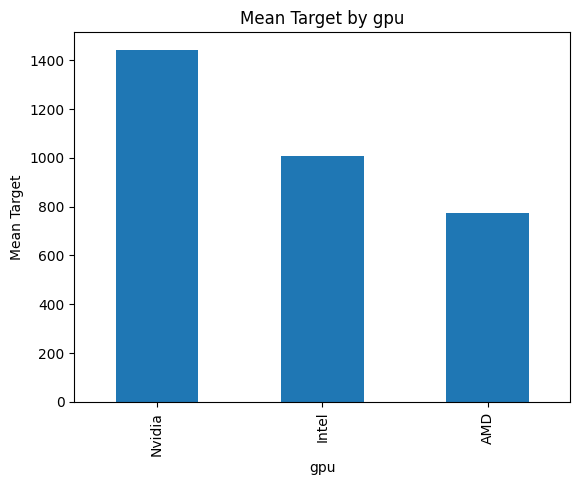

In [65]:
gpu_means = train.groupby('gpu')[target].mean()
gpu_means=gpu_means.sort_values(ascending=False)

# Visualiza los resultados
gpu_means.plot(kind='bar')
plt.xlabel('gpu')
plt.ylabel('Mean Target')
plt.title('Mean Target by gpu')
plt.show()

In [66]:
ordinal_encoding = {gpu: index for index, gpu in enumerate(gpu_means.sort_values(ascending=False).index)}

train['gpu'] = train['gpu'].map(ordinal_encoding)
test['gpu'] = test['gpu'].map(ordinal_encoding)

In [67]:
test["gpu"].fillna(3, inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      391 non-null    int64  
 1   TypeName     391 non-null    int64  
 2   OpSys        391 non-null    int64  
 3   ram_gb       391 non-null    int32  
 4   weight_kg    391 non-null    float64
 5   retina       391 non-null    int32  
 6   ips          391 non-null    int32  
 7   touchscreen  391 non-null    int32  
 8   resolution   391 non-null    float64
 9   cpu          391 non-null    float64
 10  gpu          391 non-null    float64
 11  inches       391 non-null    int64  
 12  storage      391 non-null    int64  
dtypes: float64(4), int32(4), int64(5)
memory usage: 44.8 KB


In [68]:
train

,Company,TypeName,OpSys,Price_in_euros,ram_gb,weight_kg,retina,ips,touchscreen,resolution,cpu,gpu,inches,storage
755,11,4,4,539.00,8,1.86,0,0,0,9,3,1,3,2
618,10,1,4,879.01,16,2.59,0,0,0,9,1,0,3,4
909,11,4,4,900.00,8,2.04,0,0,0,9,1,0,3,4
2,5,2,0,898.94,8,1.34,0,0,0,10,3,1,2,2
286,10,4,5,428.00,4,2.25,0,0,0,9,3,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,10,4,4,800.00,8,2.20,0,0,0,9,3,2,3,2
1160,11,3,4,1629.00,8,1.48,0,0,1,9,1,1,2,2
78,13,4,6,519.00,8,2.20,0,0,0,9,1,1,3,5
23,11,4,6,258.00,4,1.86,0,0,0,12,5,2,3,2


### modelo base

In [69]:
train, val = train_test_split(train, test_size=.2, random_state=42)

In [70]:
X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]

In [71]:
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(verbosity=0)
lgbm = LGBMRegressor(verbosity=0)

base_models = rf, xgb, lgbm
modelos = ["Random Forest", "XGBoost", "LightGBM"]

for model, nombre in zip(base_models, modelos):
    model.fit(X_train, y_train)
    cv = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error").mean())
    print(nombre, cv)

Random Forest 312.4934882980895
XGBoost 328.1591597076525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [72]:
y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

375.4984108582082

In [73]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
grid_pred = grid_search.best_estimator_.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, grid_pred))
rmse

379.9267391680075

In [74]:
pred = grid_search.best_estimator_.predict(test)

#### menos features manualmente

In [75]:
importancias = grid_search.best_estimator_.feature_importances_
importancias

array([0.04443497, 0.32308064, 0.02219044, 0.36635552, 0.12277356,
       0.00038619, 0.00924751, 0.00804965, 0.04782888, 0.02787169,
       0.00497867, 0.00704872, 0.01575357])

In [76]:
# Obtener los nombres de las características originales
nombres_caracteristicas = X_train.columns

# Crear un DataFrame para visualizar las importancias de las características
importancias_df = pd.DataFrame({'Feature': nombres_caracteristicas, 'Importance': importancias})

# Ordenar las características por importancia descendente
importancias_df = importancias_df.sort_values('Importance', ascending=False)

# Mostrar las características y sus importancias
importancias_df

,Feature,Importance
3,ram_gb,0.366356
1,TypeName,0.323081
4,weight_kg,0.122774
8,resolution,0.047829
0,Company,0.044435
9,cpu,0.027872
2,OpSys,0.022190
12,storage,0.015754
6,ips,0.009248
7,touchscreen,0.008050


In [77]:
feat_importantes = importancias_df["Feature"].iloc[:8].tolist()

In [78]:
grid_search.fit(X_train[feat_importantes], y_train)
grid_pred = grid_search.best_estimator_.predict(X_val[feat_importantes])
rmse = np.sqrt(mean_squared_error(y_val, grid_pred))
rmse

376.699113924216

In [81]:
X_train.head()

,Company,TypeName,OpSys,ram_gb,weight_kg,retina,ips,touchscreen,resolution,cpu,gpu,inches,storage
1118,11,0,1,8,3.00,0,1,0,9,1,2,3,4
153,10,1,4,16,2.56,0,0,0,9,1,0,3,3
275,5,2,0,8,1.37,1,1,0,4,1,1,2,3
1100,11,4,1,4,1.54,0,0,0,9,1,1,2,2
131,10,4,4,16,2.80,0,0,0,9,3,2,3,5


In [80]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 1118 to 418
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      729 non-null    int64  
 1   TypeName     729 non-null    int64  
 2   OpSys        729 non-null    int64  
 3   ram_gb       729 non-null    int32  
 4   weight_kg    729 non-null    float64
 5   retina       729 non-null    int32  
 6   ips          729 non-null    int32  
 7   touchscreen  729 non-null    int32  
 8   resolution   729 non-null    int64  
 9   cpu          729 non-null    int64  
 10  gpu          729 non-null    int64  
 11  inches       729 non-null    int64  
 12  storage      729 non-null    int64  
dtypes: float64(1), int32(4), int64(8)
memory usage: 68.3 KB


## catboost

In [83]:
cat_col = X_train.columns.to_list()
cat_col.remove("weight_kg")

In [85]:
cat_col

['Company',
 'TypeName',
 'OpSys',
 'ram_gb',
 'retina',
 'ips',
 'touchscreen',
 'resolution',
 'cpu',
 'gpu',
 'inches',
 'storage']

In [91]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_col)

cb = CatBoostRegressor(n_estimators=200,
                      loss_function='RMSE',
                       learning_rate=0.4,
                       random_state=1,
                       verbose = False
                      )

cb.fit(train_pool)

In [92]:
test["resolution"] = test["resolution"].astype(int)
test["gpu"] = test["gpu"].astype(int)
test["cpu"] = test["cpu"].astype(int)

In [93]:
pred = cb.predict(test)
pred